# Load libraries

In [17]:
%load_ext autoreload
%autoreload 2


# Basic libraries
import pandas as pd
import numpy as np
import sys


# Scipy
import scipy
from scipy import signal
from scipy.linalg import solve
from scipy import constants
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

# Locate files
import os
from pathlib import Path
from glob import glob

# Plots
from matplotlib import pyplot as plt

#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data
from joblib import Parallel, delayed

""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs

from   SEA import SEA
import three_D_funcs as threeD
import download_data as download

sys.path.insert(1, os.path.join(os.getcwd(), 'functions/3d_anis_analysis_toolboox'))
import collect_wave_coeffs 
import data_analysis 






os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"

/Users/nokni/work/MHDTurbPy/pyspedas/pyspedas/__init__.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download  WIND data

In [18]:
from joblib import Parallel, delayed

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)

save_destination        =  f'/Users/nokni/work/MHDTurbPy/examples'


cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path

#User defined parameters
credentials             =      { 'psp':{
                                           'fields': {'username': None, 'password': None},
                                           'sweap' : {'username': None, 'password': None}}}


settings                =  {
                            'Data_path'              : '/Volumes/Zesen-4TB/SPEDAS/' ,
                            'Only_1_interval'        :  True,                 # If you only want to check one interval
                            'start_date'             : '2018-11-01 00:00', 
                            'end_date'               : '2018-11-02 00:00',
                            'overwrite_files'        :  1,                     # In case you want to re-do analysis for existing files!
                            'save_all'               :  True,                  # If false it will only keep derived quants. Not timeseries
                            'sc'                     : 'WIND',                 # Choices ['PSP', SOLO, 'HELIOS_A', 'HELIOS_B', 'WIND']
                            'part_resol'             : 3,                      # Max resol of plasma data                [s]
                            'MAG_resol'              : 1,                      # Max resol og magnetic field data        [s]

                            
                            'duration'               : '10H',                  # Duration of interval (in Hours)
                            'Step'                   : '5H',                   # Move starting point by step (in Hours)
                            'estimate_derived_param' :  True,
                            'Big_Gaps'               :{
                                                        'Mag_big_gaps' : 10,   # This will return 3 dtaframes containing gaps
                                                        'Par_big_gaps' : 20,   # in the respective timeseries
                                                        'QTN_big_gaps' : 300,
                                                        
                                                        },
                                                    
                            'cut_in_small_windows'   : {'flag'    : False, 
                                                        'Step'    : '10min',
                                                        'duration': '600min'},

                            'Max_par_missing'        : 10,
                            'addit_time_around'      : 4,                       # [start_time -addit_time_around [h], end_time + addit_time_around [h]]
                            'gap_time_threshold'     : 5 ,                      # Threshold for large gaps (units of seconds)
                            'apply_hampel'           : False,                   # Use hampelfilter to despike plasma data
                            'hampel_params'          : {'w'  : 200,
                                                        'std': 3},

                            'upsample_low_freq_ts'   : False,                    #
                            'estimate_psd_b'         : 1,                       # Estimate magentic field powes spectral density (keep false)
                            'estimate_psd_v'         : 1,                       # Estimate velocity field powes spectral density (keep false)
                            'est_PSD_components'     : 1,
                            'smooth_psd'             : False,
                            'in_rtn'                 : True,                    # RTN or spacecraft frame ( We will usually use RTN)
                            'rol_mean'               : True,                    # To estimate fluctuations of mag, vel field
                            'rol_window'             : '1H',                    # When estimating fluctuations, size of window (centered around -w/2 -w/2

                            } 



if settings['sc'] == "PSP":
    vars_2_downnload = {
                        'mag'    : None, 
                        'span'   : None,
                        'span-a' : None,
                        'spc'    : None, 
                        'qtn'    : None,
                        'ephem'  : None}

elif settings['sc'] == "SOLO":
    vars_2_downnload = {
                        'mag'    : None,
                        'swa'    : None, 
                        'rpw'    : None, # Default is 'bia-density-10-seconds', but  'bia-density' is also available and probaly interesting
                        'ephem'  : None} 
else:
    
    vars_2_downnload = None
    

save_path = Path(save_destination).joinpath(settings['sc'])



generated_interval_list = download.generate_intervals(settings['start_date'],
                                                     settings['end_date'], 
                                                     settings            = settings,
                                                     data_path           = settings['Data_path'])


# Call function
Parallel(n_jobs=1)(delayed(download.download_files)(
                                                            jj, 
                                                            generated_interval_list, 
                                                            settings, 
                                                            vars_2_downnload, 
                                                            cdf_lib_path, 
                                                            credentials, 
                                                            save_path) for jj in range(len(generated_interval_list)))


14-Feb-24 13:06:47: Generating only one interval based on the provided start and end times.
14-Feb-24 13:06:47: Start Time: 2018-11-01 00:00:00
14-Feb-24 13:06:47: End Time: 2018-11-02 00:00:00
14-Feb-24 13:06:47: Considering an interval spanning: 2018-11-02 00:00:00 to 2018-11-01 00:00:00
14-Feb-24 13:06:47: Overwriting folder /Users/nokni/work/MHDTurbPy/examples/WIND/2018-11-01_00-00-00_2018-11-02_00-00-00_sc_0


Working on WIND data


14-Feb-24 13:06:56: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'



Done.
Input tstart = 2018-10-31 20:00:00+00:00, tend = 2018-11-02 04:00:00+00:00
Returned tstart = 2018-10-31 20:00:00.091000, tend = 2018-11-02 03:59:59.995000
Mag fraction missing 0.0
Par fraction missing 8.943351607008491
0 out of 1 finished


[None]

# Now check downloaded interval

### (1) Locate files

In [3]:
sc        = 'WIND'
load_path =   f'/Users/nokni/work/MHDTurbPy/examples/{sc}'

finnames  = func.load_files(load_path, 'final.pkl')
gennames  = func.load_files(load_path, 'general.pkl')
signames  = func.load_files(load_path, 'sig_c_sig_r.pkl')
maggaps   = func.load_files(load_path, 'mag_gaps.pkl')

/Users/nokni/work/MHDTurbPy/examples/WIND/*/final.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/general.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/sig_c_sig_r.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/mag_gaps.pkl


### (2) Load files

In [4]:
N   = 0

fin      = pd.read_pickle(finnames[N])
gen      = pd.read_pickle(gennames[N])
sig      = pd.read_pickle(signames[N])
mag_gaps = pd.read_pickle(maggaps[N])

### Check general info

In [72]:
gen

{'Start_Time': Timestamp('2018-11-01 00:00:00'),
 'End_Time': Timestamp('2018-11-01 23:59:59.790000'),
 'd': 1.0,
 'Fraction_missing_MAG': 0.0,
 'Fract_large_gaps': 0.705440957890441,
 'Resolution_MAG': 93.10009768535646,
 'part_flag': None,
 'qtn_flag': None,
 'Fraction_missing_part': 8.943351607008491,
 'Resolution_part': 3415.3435278215948,
 'sc': 'WIND'}

### Mag field gaps

This intervals has a lot of gaps!


In [73]:
mag_gaps 

Start                     End
0  2018-11-01 05:13:41.840 2018-11-01 05:20:08.332
1  2018-11-01 05:19:31.440 2018-11-01 07:40:35.531
2  2018-11-01 07:39:03.439 2018-11-01 07:53:46.731
3  2018-11-01 07:53:27.779 2018-11-01 08:05:25.931
4  2018-11-01 08:05:07.347 2018-11-01 08:10:20.423
5  2018-11-01 08:10:01.839 2018-11-01 08:16:46.730
6  2018-11-01 08:16:21.154 2018-11-01 08:31:11.530
7  2018-11-01 08:30:52.210 2018-11-01 09:10:26.730
8  2018-11-01 09:09:49.838 2018-11-01 09:29:09.130
9  2018-11-01 09:28:50.546 2018-11-01 09:56:45.130
10 2018-11-01 09:56:22.498 2018-11-01 09:59:12.330
11 2018-11-01 09:58:51.906 2018-11-01 11:00:13.929
12 2018-11-01 10:59:37.037 2018-11-01 11:49:54.729
13 2018-11-01 11:49:31.729 2018-11-01 12:06:09.929
14 2018-11-01 12:05:51.345 2018-11-01 12:19:39.621
15 2018-11-01 12:19:18.001 2018-11-01 12:46:38.729
16 2018-11-01 12:46:16.465 2018-11-01 12:53:23.529
17 2018-11-01 12:53:04.945 2018-11-01 13:06:16.329
18 2018-11-01 13:05:55.905 2018-11-01 18:52:48.327

### Check particle data

In [74]:
fin['Par'].keys()

dict_keys(['dict_psd', 'mean_sw_speed  ', 'median_sw_speed', 'std_sw_speed', 'median_alfv_speed', 'mean_alfv_speed', 'std_alfv_speed', 'median_MA_r', 'mean_MA_r', 'std_MA_r', 'beta_mean', 'beta_std', 'sigma_r_mean', 'sigma_r_median', 'sigma_r_std', 'sigma_c_median', 'sigma_c_mean', 'sigma_c_std', 'Vth_mean', 'Vth_std', 'Vsw_mean', 'Vsw_std', 'Np_mean', 'Np_std', 'di_mean', 'di_std', 'rho_ci_mean', 'rho_ci_std', 'VBangle_mean', 'VBangle_std', 'V_resampled'])

# Magnetic field timeseries

In [75]:
fin['Mag']['B_resampled']

Br        Bt        Bn      Btot
Epoch                                                          
2018-10-31 23:59:58.874       NaN       NaN       NaN       NaN
2018-11-01 00:00:01.952 -4.029912  3.626310  1.854299  5.729825
2018-11-01 00:00:05.048 -4.012482  3.654009  1.843570  5.731592
2018-11-01 00:00:08.144 -4.038755  3.636977  1.847563  5.740543
2018-11-01 00:00:11.240 -4.085271  3.710239  1.823587  5.812221
...                           ...       ...       ...       ...
2018-11-01 23:59:41.254 -2.766150  2.214558 -1.008395  3.683182
2018-11-01 23:59:44.350 -2.793847  2.244639 -0.821334  3.676783
2018-11-01 23:59:47.446 -2.798475  2.235275 -0.841385  3.679430
2018-11-01 23:59:50.541 -2.787964  2.252897 -0.826095  3.678837
2018-11-01 23:59:53.637 -2.803601  2.256812 -0.789175  3.684956

[25412 rows x 4 columns]

# Estimate resolution of Magnetic field timeseries:

In [76]:
func.find_cadence(fin['Mag']['B_resampled'])

3.3999088941361673

# Plot estimated power spectra for magnetc field

Don't be confused by R, T, N. Those are (x,y,z)

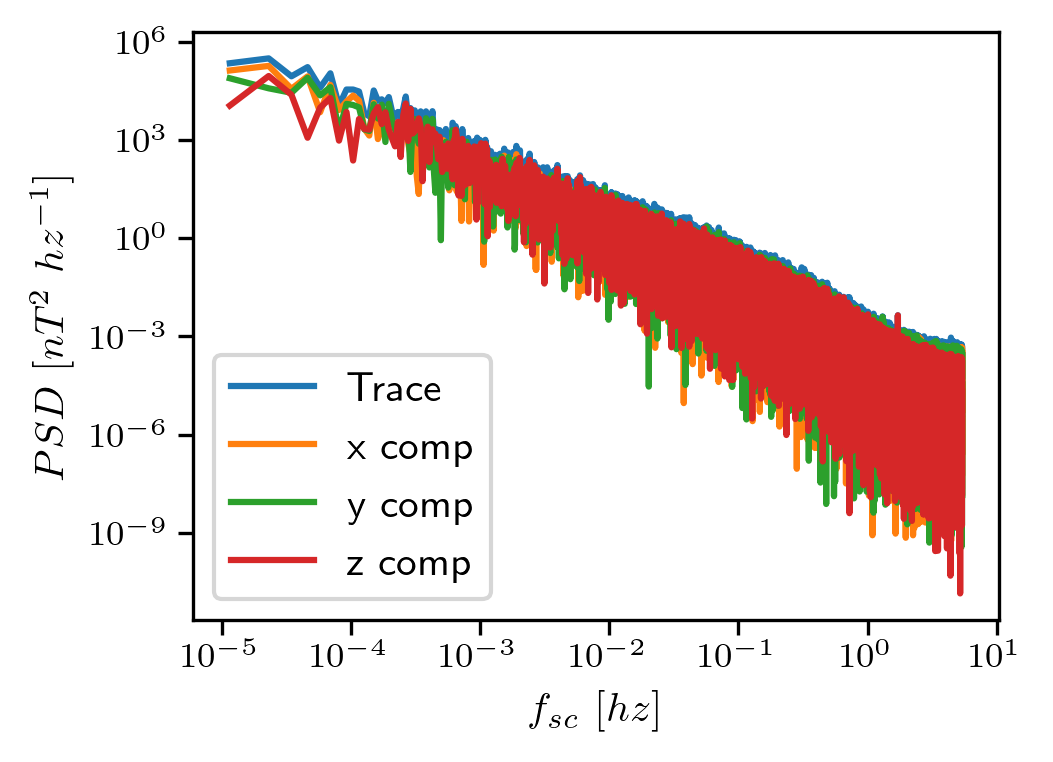

In [77]:
fig, ax =figs.initializeFigure(r'$PSD ~[nT^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'], label ='Trace')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_R'], label ='x comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_T'], label ='y comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_N'], label ='z comp')

plt.legend()

# Particle timeseries

(a) Contains Vx, Vy, Vz [km/s], proton density [cm^-3], Proton temp [ev], Proton thermal speed [km/s]

In [78]:
fin['Par']['V_resampled']

Vr         Vt         Vn        np        Tp  \
2018-10-31 23:59:58.874 -331.652466  -1.857373  10.215549  8.213666  3.175972   
2018-11-01 00:00:01.952 -331.652466   0.000000  10.215549  8.599883  3.305206   
2018-11-01 00:00:05.048 -331.652466   0.000000  10.215549  8.188411  3.331877   
2018-11-01 00:00:08.144 -333.273468   0.000000  11.198705  8.158342  3.301878   
2018-11-01 00:00:11.240 -333.273468   0.000000  11.198705  8.568443  3.278011   
...                             ...        ...        ...       ...       ...   
2018-11-01 23:59:41.254 -347.300781  29.303211  -3.903457  6.571520  4.605794   
2018-11-01 23:59:44.350 -347.300781  29.303211  -3.903457  6.567027  4.689414   
2018-11-01 23:59:47.446 -345.546265  30.129732  -4.856009  6.598980  4.636713   
2018-11-01 23:59:50.541 -347.300781  29.303211  -4.879321  6.584585  4.382844   
2018-11-01 23:59:53.637 -347.492065  27.360880  -3.903457  6.574757  4.548961   

                              Vth  
2018-10-31 23:59:58.874  0.228980  
2018-11-01 00:00:01.952  0.233592  
2018-11-01 00:00:05.048  0.234533  
2018-11-01 00:00:08.144  0.233475  
2018-11-01 00:00:11.240  0.232629  
...                           ...  
2018-11-01 23:59:41.254  0.275747  
2018-11-01 23:59:44.350  0.278239  
2018-11-01 23:59:47.446  0.276671  
2018-11-01 23:59:50.541  0.268991  
2018-11-01 23:59:53.637  0.274041  

[27908 rows x 6 columns]

# Plot estimated power spectra for several quantities

Don't be confused by R, T, N. Those are (x,y,z)

In [79]:
fin['Par']['dict_psd']

{'f_zpm': array([1.31411107e-05, 2.62822214e-05, 3.94233321e-05, ...,
        6.06068025e-02, 6.06199436e-02, 6.06330848e-02]),
 'psd_v': array([1.92119253e+10, 4.32266938e+06, 2.15933752e+06, ...,
        4.18447647e+01, 1.04306472e+01, 4.28854431e+01]),
 'psd_b': array([5.75739079e+05, 3.08213144e+06, 2.14264852e+06, ...,
        8.97516745e+00, 1.58079163e+01, 5.17862997e+00]),
 'psd_b_R': array([2.43163878e+04, 6.65745624e+05, 8.35666603e+05, ...,
        2.80592750e+00, 6.33702504e+00, 1.08155826e+00]),
 'psd_b_T': array([3.49828106e+05, 1.38657368e+05, 4.15555807e+05, ...,
        2.02248346e+00, 6.92402119e+00, 3.21741701e+00]),
 'psd_b_N': array([2.01594584e+05, 2.27772845e+06, 8.91426113e+05, ...,
        4.14675649e+00, 2.54687011e+00, 8.79654703e-01]),
 'psd_zp': array([1.83145080e+10, 7.14599686e+06, 4.10122960e+06, ...,
        9.03122010e+01, 3.26783168e+01, 6.35507531e+01]),
 'psd_zm': array([2.01413059e+10, 4.92672940e+06, 4.06198613e+06, ...,
        7.63133533e+01, 2.

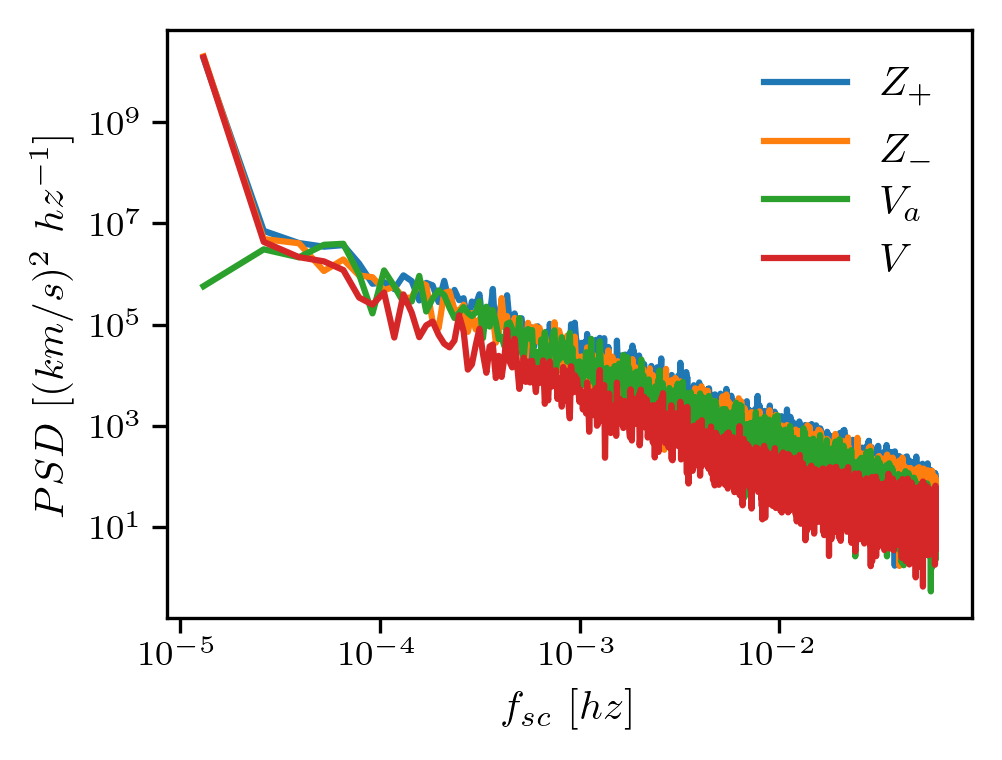

In [8]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zp'], label =r'$Z_{+}$')
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zm'], label =r'$Z_{-}$')

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_b'], label =r'$V_a$')
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], label =r'$V$')
plt.legend(frameon=0)

# Plot cross heicity spectrum

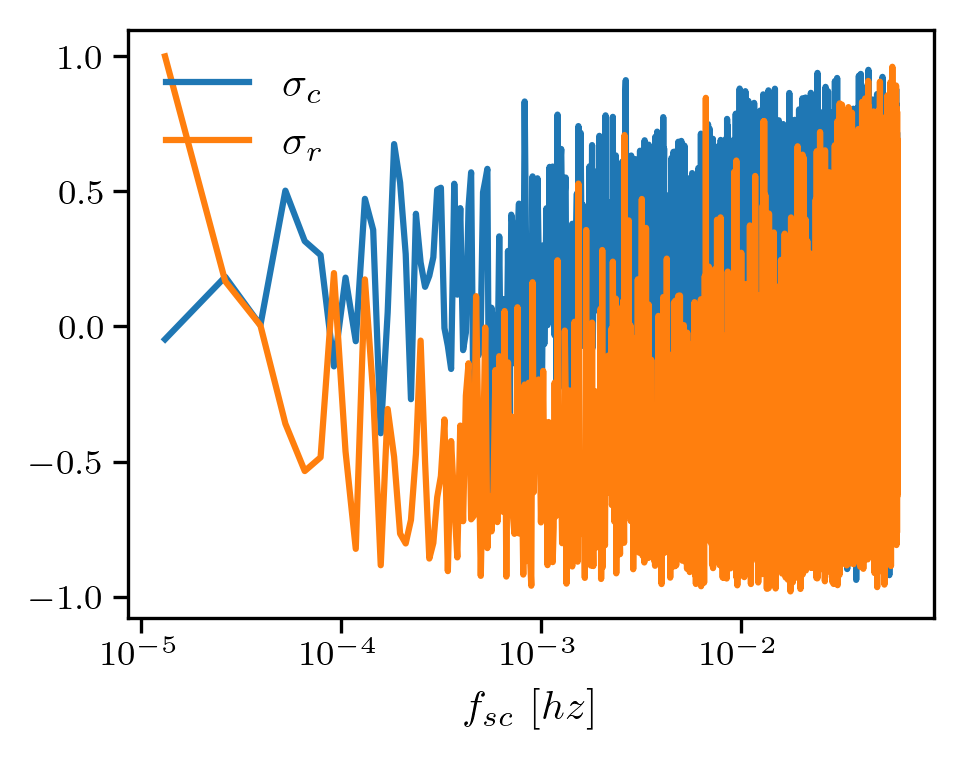

In [97]:
fig, ax =figs.initializeFigure(r'', r'$f_{sc} ~[hz]$')


zp = fin['Par']['dict_psd']['psd_zp']
zm = fin['Par']['dict_psd']['psd_zm']

va = fin['Par']['dict_psd']['psd_b']
v  = fin['Par']['dict_psd']['psd_v']

plt.yscale('linear')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm), label =r'$\sigma_c$')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va), label =r'$\sigma_r$')

plt.legend(frameon=0)

# You can also smooth the PSD

In [81]:
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])

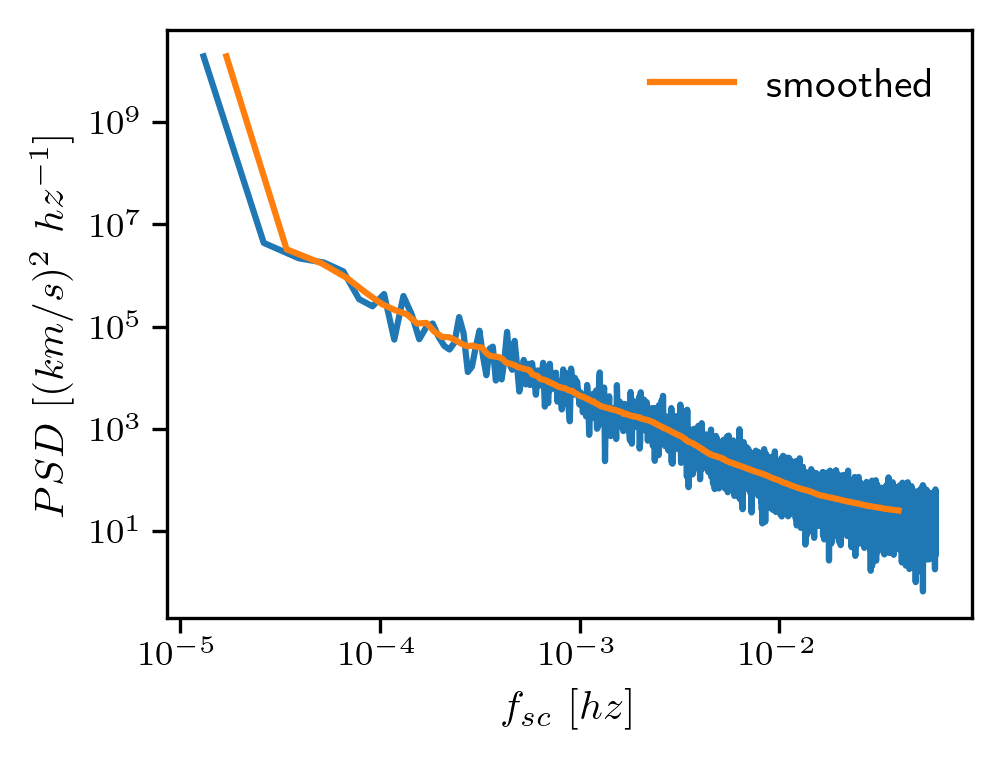

In [82]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')
plt.legend(frameon=0)

# Fit the PSD

12-Feb-24 14:15:50: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_65755/626478110.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-." (-> linestyle='-.'). The keyword argument will take precedence.
  plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name)



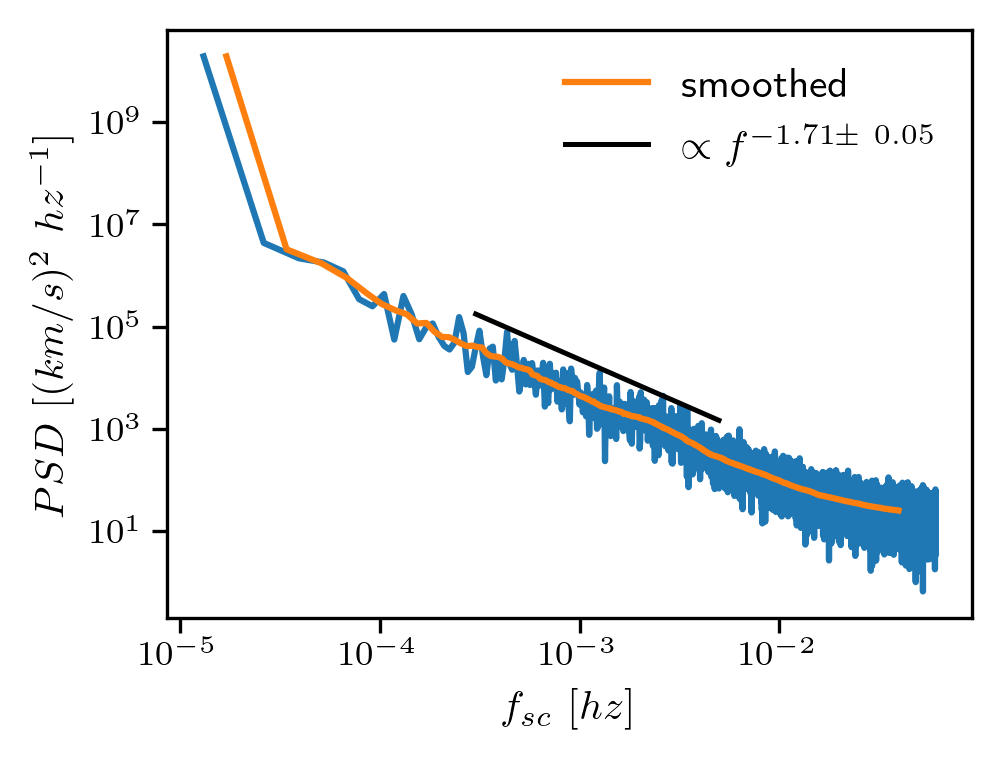

In [83]:
x0, xf = 3e-4, 5e-3

fit, s, e, x, y = func.find_fit(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], x0, xf)

lab_name =r'$\propto f^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit[0][1],2), round(np.sqrt(fit[1][1][1]),2))


fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')


plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name) 



plt.legend(frameon=0)

# Estimate resolution of Particle timeseries:

In [84]:
func.find_cadence(fin['Par']['V_resampled'])

3.0958097609918664

# Plot derived quantities

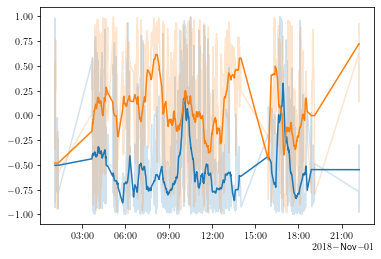

In [93]:
wind = '30min'

plt.plot(sig.sigma_r, c='C0', alpha=0.2)
plt.plot(sig.sigma_c,  c='C1', alpha=0.2)


# Smoothed version
plt.plot(sig.sigma_r.rolling(wind, center=True).mean().interpolate(), c='C0')
plt.plot(sig.sigma_c.rolling(wind, center=True).mean().interpolate(), c='C1')


# More derived quantities. To understand what those are look at /functions/calc_diagnostics.py

In [94]:
sig.keys()

Index(['dZpr', 'dZpt', 'dZpn', 'dZmr', 'dZmt', 'dZmn', 'dva_r', 'dva_t',
       'dva_n', 'dv_r', 'dv_t', 'dv_n', 'beta', 'np', 'Tp', 'VB', 'd_i', 'Ma',
       'Vsw', 'kin_norm', 'Ma_r_ts', 'sigma_c', 'Va', 'sigma_r'],
      dtype='object')